In [1]:
import numpy as np
import pandas as pd #data wrangeling
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import os #for setting the working drectory

In [2]:
import pyramid

In [3]:
import pmdarima

In [4]:
from pmdarima import auto_arima

In [110]:
from statsmodels.tsa.arima_model import ARIMA

In [6]:
#setting working directory
os.chdir("C:/Users/mah/Desktop/M5_Wallmart_Challenge")
os.getcwd()

'C:\\Users\\mah\\Desktop\\M5_Wallmart_Challenge'

In [7]:
#importing data
sales_train_validation = pd.read_csv("sales_train_validation.csv") #Sales per Item
calendar = pd.read_csv("calendar.csv", parse_dates=['date']) #Calender Information
sell_prices = pd.read_csv("sell_prices.csv") #Prices per Item

#LL: the sales_train_validation data frame is very large, it couldent load because I didn't have enough memory.
#When I closed most of my tabs it worked.
#I also had problems in merging data sets, it either gave back that hte memory was insfficient or took long (over 30 min).
#Somehow it works better after restarting the computer
#Closing tabs doesn't have the same effect
#Further note that after restarting the computer and installing
#
#The parse_dates command makes python recognise the data variable in the sales and calendar data as dates
#Alternatively doing it manually after reading the data: (here the example for the calendar)
#calendar['date'] = pd.to_datetime(calendar['date'], format='%Y/%m/%d')

In [8]:
#inspection of sales amount data
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [9]:
#inspection of price data
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [10]:
#inspecting calendar data
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [11]:
#merging calendar and price data depent on the week, year and month
#Note: Price are only provided as weekly averages
calendar_sell_prices = pd.merge(sell_prices, calendar, on='wm_yr_wk')
calendar_sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,date,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,HOBBIES_1_001,11325,9.58,2013-07-13,Saturday,1,7,2013,d_897,NaN,NaN,NaN,NaN,0,1,0
1,CA_1,HOBBIES_1_001,11325,9.58,2013-07-14,Sunday,2,7,2013,d_898,NaN,NaN,NaN,NaN,0,0,1
2,CA_1,HOBBIES_1_001,11325,9.58,2013-07-15,Monday,3,7,2013,d_899,NaN,NaN,NaN,NaN,0,1,1
3,CA_1,HOBBIES_1_001,11325,9.58,2013-07-16,Tuesday,4,7,2013,d_900,NaN,NaN,NaN,NaN,0,0,0
4,CA_1,HOBBIES_1_001,11325,9.58,2013-07-17,Wednesday,5,7,2013,d_901,NaN,NaN,NaN,NaN,0,0,0


In [12]:
##### not required step ####

#reducing calendar and price data to one product in one store
calendar_sell_prices.loc[(calendar_sell_prices['item_id'] == 'HOBBIES_1_001') & (calendar_sell_prices['store_id'] == 'CA_1')]  

,store_id,item_id,wm_yr_wk,sell_price,date,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,CA_1,HOBBIES_1_001,11325,9.58,2013-07-13,Saturday,1,7,2013,d_897,NaN,NaN,NaN,NaN,0,1,0
1,CA_1,HOBBIES_1_001,11325,9.58,2013-07-14,Sunday,2,7,2013,d_898,NaN,NaN,NaN,NaN,0,0,1
2,CA_1,HOBBIES_1_001,11325,9.58,2013-07-15,Monday,3,7,2013,d_899,NaN,NaN,NaN,NaN,0,1,1
3,CA_1,HOBBIES_1_001,11325,9.58,2013-07-16,Tuesday,4,7,2013,d_900,NaN,NaN,NaN,NaN,0,0,0
4,CA_1,HOBBIES_1_001,11325,9.58,2013-07-17,Wednesday,5,7,2013,d_901,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30622813,CA_1,HOBBIES_1_001,11620,8.38,2016-06-15,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
30622814,CA_1,HOBBIES_1_001,11620,8.38,2016-06-16,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
30622815,CA_1,HOBBIES_1_001,11620,8.38,2016-06-17,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
30836239,CA_1,HOBBIES_1_001,11621,8.38,2016-06-18,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [13]:
#reducing calendar and price data to store, item, price and day
#Note: minimum necessary to merge with the sales amount data + date variable
calendar_sell_prices_reduced = calendar_sell_prices.drop(
    ['wm_yr_wk','weekday','wday','month','year',
     'event_name_1','event_type_1', 'event_name_2', 
     'event_type_2','snap_CA','snap_TX','snap_WI'], axis=1)
calendar_sell_prices_reduced.head()

,store_id,item_id,sell_price,date,d
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901


In [14]:
#Changing the sales data so that the day and the sold units become columns
#Note helps to combine the data with the price data by store, item and day
sales_train_validation_pivot = sales_train_validation.melt(id_vars=["id","item_id","dept_id",
                                     "cat_id","store_id","state_id"], 
                                  var_name="d", 
                                  value_name="sold_units")

sales_train_validation_pivot.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold_units
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [15]:
#merging calendar and price data with the sales data by item, store and day
sales_prices = pd.merge(calendar_sell_prices_reduced,sales_train_validation_pivot, 
         on=['item_id','store_id','d'])
sales_prices.head()

,store_id,item_id,sell_price,date,d,id,dept_id,cat_id,state_id,sold_units
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0


In [16]:
#convert the price and sales variables into floats so that they can be multiplied
sales_prices[['sell_price', 'sold_units']] = sales_prices[['sell_price', 'sold_units']].astype(float)

In [17]:
#compute the revenue and store it into a new column
#Note: here we have the revenue per item, store and day
sales_prices['revenue'] = sales_prices['sell_price']*sales_prices['sold_units']

In [18]:
sales_prices

,store_id,item_id,sell_price,date,d,id,dept_id,cat_id,state_id,sold_units,revenue
0,CA_1,HOBBIES_1_001,9.58,2013-07-13,d_897,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
1,CA_1,HOBBIES_1_001,9.58,2013-07-14,d_898,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
2,CA_1,HOBBIES_1_001,9.58,2013-07-15,d_899,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
3,CA_1,HOBBIES_1_001,9.58,2013-07-16,d_900,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
4,CA_1,HOBBIES_1_001,9.58,2013-07-17,d_901,HOBBIES_1_001_CA_1_validation,HOBBIES_1,HOBBIES,CA,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
46027952,WI_3,FOODS_3_825,4.00,2011-02-28,d_31,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,1.0,4.0
46027953,WI_3,FOODS_3_825,4.00,2011-03-01,d_32,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0
46027954,WI_3,FOODS_3_825,4.00,2011-03-02,d_33,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0
46027955,WI_3,FOODS_3_825,4.00,2011-03-03,d_34,FOODS_3_825_WI_3_validation,FOODS_3,FOODS,WI,2.0,8.0


In [19]:
#Summarizing the daily revenue of the categroy FOODS for the store CA_1 per day
#Note: sorted by date
revenue_CA_1_FOODS_day = sales_prices.loc[(sales_prices['store_id'] == 'CA_1') & 
                 (sales_prices['cat_id'] == 'FOODS')].sort_values('date').groupby(['date']).sum().drop(['sell_price','sold_units'], axis=1)
revenue_CA_1_FOODS_day

#LL:
#When Grouping and summing, all variables fall out that are not grouped by or floats.
#Floats is important because only floats can be summed up.
#In This example:
#- don't need to drop 'item_id', 'dept_id','state_id'
#- but I do need to drop 'sell_price','sold_units' as they are floats
#Droping variables can be done before or after the grouping
#
#Further note that grouping results in only one result column, thus if i need the indexes of other columns,
#The other columns need to be rejoined by extracting them from the ungrouped data set
#
#Note: I need to sort the data by the date and also group it by the date, otherwise it is in the wrong order
#
#Therefore I first do the analysis only for the aggregated Food revenue in CA_1
#Later I will make a loop and do the model for all different store category combinations
#gets every possible value of a column command for the loop:
#sales_prices.store_id.unique()
#sales_prices.cat_id.unique()
#
#Note: Hanging Python commands after one another is done with a dote '.'

,revenue
date,
2011-01-29,7240.65
2011-01-30,6705.51
2011-01-31,4584.85
2011-02-01,4965.46
2011-02-02,4368.07
...,...
2016-04-20,6938.53
2016-04-21,6824.21
2016-04-22,8226.64


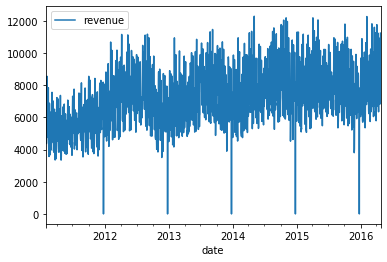

In [20]:
#Simpler plot der Ergebnisse
revenue_CA_1_FOODS_day.plot()
plt.show()

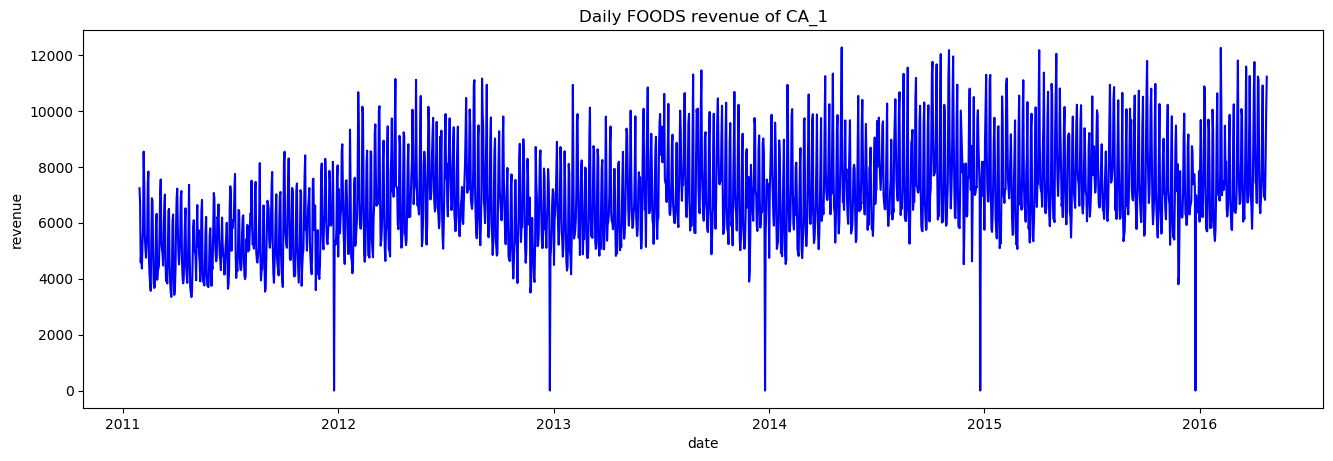

In [21]:
# Draw Plot
def plot_df(revenue_CA_1_FOODS_day, x, y, title="", xlabel='date', ylabel='revenue', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(revenue_CA_1_FOODS_day, 
        x=revenue_CA_1_FOODS_day.index, 
        y=revenue_CA_1_FOODS_day.revenue, 
        title='Daily FOODS revenue of CA_1')

#Function from: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [22]:
from statsmodels.tsa.stattools import adfuller
# Augmented Dickey Fuller Test
result = adfuller(revenue_CA_1_FOODS_day.revenue.values, autolag='AIC', maxlag=365)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
#ADF test:
#H0: time series possesses a unit root and is non-stationary
#So, if the P-Value in ADF test is less than the significance level (0.05), you reject H0, thus the series is stationary
#Here the P-Value is smaller than 10% thus at least a a 10% significane level we can say that the series is stationary
#
#Note: I define the max. lag at 365 due to yearly seasonality
#Because of the higher max.lag than is standard in the algorithm the p-value dropped significantly from 0.42 --> 0.07
#which makes the rejection of a random walk stronger
#Doing the test with maxlag=0 results in a random walk, which makes sense as we didn't control for autoregressive characteristics

ADF Statistic: -2.7067204269343144
p-value: 0.07288254399707181
Critial Values:
   1%, -3.434584120148502
Critial Values:
   5%, -2.863410105779459
Critial Values:
   10%, -2.5677656145911203


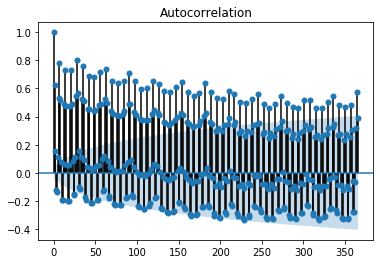

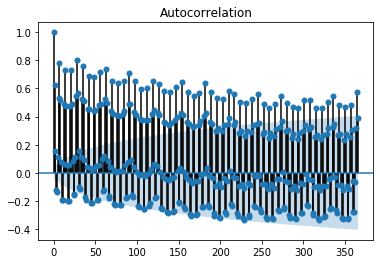

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(revenue_CA_1_FOODS_day.revenue, lags=365)

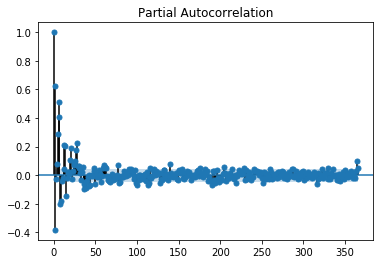

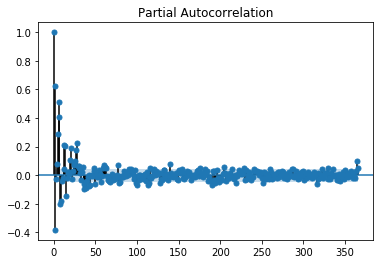

In [24]:
plot_pacf(revenue_CA_1_FOODS_day.revenue, lags=365, method='ywm')
plt.show()
#Note: I had to include the ywm method
#Tip from: https://stackoverflow.com/questions/51436580/linear-model-py1283-runtimewarning-invalid-value-encountered-in-sqrt-return-r
# I exclude the bias correction in the yule walker method

#Note: OLS Method with constant (similar results)
#plot_pacf(revenue_CA_1_FOODS_day.revenue, lags=365, method='ols')

In [243]:
#Taking out the christmas effect by assuming sales to be the mean of the sales the day before and after christmas
#Purpose: to eiminate distortions of christmas on the parameter estimates
#Alternative: Christmas dummy, but as sales rise over time one would need one dummy per christmas day

#Logic behind the Loop:
#for every row in the time series...
#if the time index (defined as time variable previously) day is equal to 25 and the monht to 12...
#Then set the revenue value of that row equal to the mean of the previous and next days revenues
for i in range(len(revenue_CA_1_FOODS_day)):
    if ((revenue_CA_1_FOODS_day.index.day[i] == 25) and (revenue_CA_1_FOODS_day.index.month[i] == 12)):
        revenue_CA_1_FOODS_day['revenue'][i] = (revenue_CA_1_FOODS_day['revenue'][i-1] + 
                                               revenue_CA_1_FOODS_day['revenue'][i+1])/2
        

In [405]:
#defining exogen variables data frame
#setting the date as the index
exog = pd.DataFrame({'date': revenue_CA_1_FOODS_day.index})

In [406]:
#defining the index as a date variable which will become relevant for subsequent computation
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

In [407]:
#Fourier Series for weekly and yearly seasonality
#N=The number of Sinus and Cosinus Terms that are included
#P=Cycle length, defined as 
#                            365.25 for yearly seasonality (due to leap years) 
#                            7 for weekly seasonality
#t=time index is defined as 
#                            the day of the year (0-365) for yearly seasonality
#                            the day of the week (0-6) for weekly seasonality
#to vsualize simply plot:
#dayofyear = pd.DataFrame({'d': exog.index.dayofweek})
#dayofyear.plot()
#dayofweek = pd.DataFrame({'d': exog.index.dayofweek})
#dayofweek.plot()

#yearly seasonality with N=10
#N=1
exog['yearly_sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
#N=2
exog['yearly_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
#N=3
exog['yearly_sin365_3'] = np.sin(6 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_3'] = np.cos(6 * np.pi * exog.index.dayofyear / 365.25)
#N=4
exog['yearly_sin365_4'] = np.sin(8 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_4'] = np.cos(8 * np.pi * exog.index.dayofyear / 365.25)
#N=5
exog['yearly_sin365_5'] = np.sin(10 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_5'] = np.cos(10 * np.pi * exog.index.dayofyear / 365.25)
#N=6
exog['yearly_sin365_6'] = np.sin(12 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_6'] = np.cos(12 * np.pi * exog.index.dayofyear / 365.25)
#N=7
exog['yearly_sin365_7'] = np.sin(14 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_7'] = np.cos(14 * np.pi * exog.index.dayofyear / 365.25)
#N=8
exog['yearly_sin365_8'] = np.sin(16 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_8'] = np.cos(16 * np.pi * exog.index.dayofyear / 365.25)
#N=9
exog['yearly_sin365_9'] = np.sin(18 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_9'] = np.cos(18 * np.pi * exog.index.dayofyear / 365.25)
#N=10
exog['yearly_sin365_10'] = np.sin(20 * np.pi * exog.index.dayofyear / 365.25)
exog['yearly_cos365_10'] = np.cos(20 * np.pi * exog.index.dayofyear / 365.25)


#weekly seasonality with N=3
#N=1
exog['weekly_sin365'] = np.sin(2 * np.pi * exog.index.dayofweek / 7)
exog['weekly_cos365'] = np.cos(2 * np.pi * exog.index.dayofweek / 7)
#N=2
exog['weekly_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofweek / 7)
exog['weekly_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofweek / 7)
#N=3
exog['weekly_sin365_3'] = np.sin(6 * np.pi * exog.index.dayofweek / 7)
exog['weekly_cos365_3'] = np.cos(6 * np.pi * exog.index.dayofweek / 7)

#linear trend
exog['linear_trend'] = [i for i in range(len(revenue_CA_1_FOODS_day))]

#drop the date variable as it is no longer needed and should not be used as exogen variable
exog = exog.drop(columns=['date'])

In [408]:
#Adding events to the exogen variables

#SNAP Food assistance program days in Califonia
#Extract snap column
Snap = calendar.loc[:1912,'snap_CA']
#Create Dummy variable by setting all NaN to 0
Snap = Snap.replace('None', 0)
#add to exogen
exog['SNAP_CA'] = np.array(Snap)

In [409]:
#defining an array with all possible holidays
#Note: event 2 only contains holidays if two holidays happen to have the same date
#Thus all holidays are included in event 1
events = calendar['event_name_1'].unique()
#omitting nan from the possible holidays
events = np.delete(events,[0])

#defining a DataFrame for the Dummys of all Holidays
exg_holi = pd.DataFrame(0, index=np.arange(len(calendar)), columns=events)

    
#Tipp:
#only use .loc if i choose a certain row and column range, 
#if I only want a column (thus al rows) then simply DataFrame name and column name in dquared brackets and paranthesis 

In [410]:
#Creating unique dummy variables for each holiday
#Each holiday gets a dummy set to one for the holiday date and the 6 days prior

#Describing the loop:
#it goes threw every event
#for each event it looks if it happens at a certain day in the calendar (event 1 or 2)
#Further it looks if the event will happen in the following 6 days
#if it happens today or in the next 6 days according to any of both event columns it sets the dummy to 1
#otherwise to zero

#Problem:
#Program cannot run for last 6 days of data as their are no more 6 future days which results in an indexing error
#I tried including an anditional condition so that it only looks for future days if they exist but it didn't work
#Code:
#for i in events:
#    for d in range(0,len(calendar)): 
#        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i)):
#            exg_holi.loc[d,i]=1
#        if ((d+1 <= len(calendar)) and ((calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        if ((d+2 <= len(calendar)) and ((calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        if ((d+3 <= len(calendar)) and ((calendar.loc[d+3,'event_name_1'] == i) or (calendar.loc[d+3,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        if ((d+4 <= len(calendar)) and ((calendar.loc[d+4,'event_name_1'] == i) or (calendar.loc[d+4,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        if ((d+5 <= len(calendar)) and ((calendar.loc[d+5,'event_name_1'] == i) or (calendar.loc[d+5,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        if ((d+6 <= len(calendar)) and ((calendar.loc[d+6,'event_name_1'] == i) or (calendar.loc[d+6,'event_name_2'] == i))):
#            exg_holi.loc[d,i]=1
#        else:
#            exg_holi.loc[d,i]=0

for i in events:
    for d in range(0,len(calendar)-6): 
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)
           or (calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i)
           or (calendar.loc[d+3,'event_name_1'] == i) or (calendar.loc[d+3,'event_name_2'] == i)
           or (calendar.loc[d+4,'event_name_1'] == i) or (calendar.loc[d+4,'event_name_2'] == i)
           or (calendar.loc[d+5,'event_name_1'] == i) or (calendar.loc[d+5,'event_name_2'] == i)
           or (calendar.loc[d+6,'event_name_1'] == i) or (calendar.loc[d+6,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
        else:
            exg_holi.loc[d,i]=0
    for d in range(len(calendar)-6,len(calendar)-5):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)
           or (calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i)
           or (calendar.loc[d+3,'event_name_1'] == i) or (calendar.loc[d+3,'event_name_2'] == i)
           or (calendar.loc[d+4,'event_name_1'] == i) or (calendar.loc[d+4,'event_name_2'] == i)
           or (calendar.loc[d+5,'event_name_1'] == i) or (calendar.loc[d+5,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-4):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)
           or (calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i)
           or (calendar.loc[d+3,'event_name_1'] == i) or (calendar.loc[d+3,'event_name_2'] == i)
           or (calendar.loc[d+4,'event_name_1'] == i) or (calendar.loc[d+4,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-3):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)
           or (calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i)
           or (calendar.loc[d+3,'event_name_1'] == i) or (calendar.loc[d+3,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-2):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)
           or (calendar.loc[d+2,'event_name_1'] == i) or (calendar.loc[d+2,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-1):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i) 
           or (calendar.loc[d+1,'event_name_1'] == i) or (calendar.loc[d+1,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)):
        if ((calendar.loc[d,'event_name_1'] == i) or (calendar.loc[d,'event_name_2'] == i)):
            exg_holi.loc[d,i]=1
            
            
#Tipp:
#only use .loc if i choose a certain row and column range, 
#if I only want a column (thus al rows) then simply DataFrame name and column name in dquared brackets and paranthesis 

In [411]:
#Note: to combine/merge the individual holiday data with the other exogenous data they need a common variable or index
#Thus i put the date variable into the exg_holi data prior to mergin on date
exg_holi['date']=calendar['date']
#then i define the index as the date variable so that the indices of both data sets are identical
exg_holi = exg_holi.set_index(pd.PeriodIndex(exg_holi['date'], freq='D'))
#drop the date variable as it is no longer needed and should not be used as exogen variable
exg_holi = exg_holi.drop(columns=['date'])

In [414]:
#merging the data sets
#Note: by setting the indexes for both sets to true I merge by the index
exog_unique = pd.merge(exog,exg_holi, left_index=True, right_index=True)

#Tipp:
#read up on how to merge here
#https://realpython.com/pandas-merge-join-and-concat/#how-to-add-to-a-dataframe-with-append

In [440]:
#defining an array with all possible holiday categories
#Note: event 2 only contains holidays if two holidays happen to have the same date
#Thus all holidays are included in event 1
events = calendar['event_type_1'].unique()
#omitting nan from the possible holidays
events = np.delete(events,[0,5])
#Note: need to delete first and last index

#defining a DataFrame for the Dummys of all Holiday typs
exg_cate = pd.DataFrame(0, index=np.arange(len(calendar)), columns=events)


In [441]:
#Definition of dummy variables for each category of holidays
#In analogy to the definition per holiday: 7 day period
for i in events:
    for d in range(0,len(calendar)-6): 
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)
           or (calendar.loc[d+2,'event_type_1'] == i) or (calendar.loc[d+2,'event_type_2'] == i)
           or (calendar.loc[d+3,'event_type_1'] == i) or (calendar.loc[d+3,'event_type_2'] == i)
           or (calendar.loc[d+4,'event_type_1'] == i) or (calendar.loc[d+4,'event_type_2'] == i)
           or (calendar.loc[d+5,'event_type_1'] == i) or (calendar.loc[d+5,'event_type_2'] == i)
           or (calendar.loc[d+6,'event_type_1'] == i) or (calendar.loc[d+6,'event_type_2'] == i)):
            exg_cate.loc[d,i]=1
        else:
            exg_cate.loc[d,i]=0
    for d in range(len(calendar)-6,len(calendar)-5):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)
           or (calendar.loc[d+2,'event_type_1'] == i) or (calendar.loc[d+2,'event_type_2'] == i)
           or (calendar.loc[d+3,'event_type_1'] == i) or (calendar.loc[d+3,'event_type_2'] == i)
           or (calendar.loc[d+4,'event_type_1'] == i) or (calendar.loc[d+4,'event_type_2'] == i)
           or (calendar.loc[d+5,'event_type_1'] == i) or (calendar.loc[d+5,'event_type_2'] == i)):
            exg_cate.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-4):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)
           or (calendar.loc[d+2,'event_type_1'] == i) or (calendar.loc[d+2,'event_type_2'] == i)
           or (calendar.loc[d+3,'event_type_1'] == i) or (calendar.loc[d+3,'event_type_2'] == i)
           or (calendar.loc[d+4,'event_type_1'] == i) or (calendar.loc[d+4,'event_type_2'] == i)):
            exg_cate.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-3):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)
           or (calendar.loc[d+2,'event_type_1'] == i) or (calendar.loc[d+2,'event_type_2'] == i)
           or (calendar.loc[d+3,'event_type_1'] == i) or (calendar.loc[d+3,'event_type_2'] == i)):
            exg_cate.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-2):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)
           or (calendar.loc[d+2,'event_type_1'] == i) or (calendar.loc[d+2,'event_type_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)-1):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i) 
           or (calendar.loc[d+1,'event_type_1'] == i) or (calendar.loc[d+1,'event_type_2'] == i)):
            exg_holi.loc[d,i]=1
    for d in range(len(calendar)-6,len(calendar)):
        if ((calendar.loc[d,'event_type_1'] == i) or (calendar.loc[d,'event_type_2'] == i)):
            exg_cate.loc[d,i]=1
            
            

In [442]:
#Note: to combine/merge the individual holiday data with the other exogenous data they need a common variable or index
#Thus i put the date variable into the exg_holi data prior to mergin on date
exg_cate['date']=calendar['date']
#then i define the index as the date variable so that the indices of both data sets are identical
exg_cate = exg_cate.set_index(pd.PeriodIndex(exg_cate['date'], freq='D'))
#drop the date variable as it is no longer needed and should not be used as exogen variable
exg_cate = exg_cate.drop(columns=['date'])

In [443]:
#merging the data sets
#Note: by setting the indexes for both sets to true I merge by the index
exog_category = pd.merge(exog,exg_cate, left_index=True, right_index=True)

In [463]:
#Define training and testing data set
#for exogenous variables
exog_unique_to_train = exog_unique.iloc[:(len(revenue_CA_1_FOODS_day)-31)]
exog_unique_to_test = exog_unique.iloc[(len(revenue_CA_1_FOODS_day)-31):]
exog_category_to_train = exog_category.iloc[:(len(revenue_CA_1_FOODS_day)-31)]
exog_category_to_test = exog_category.iloc[(len(revenue_CA_1_FOODS_day)-31):]
#for dependent variables
revenue_CA_1_FOODS_day_to_train = revenue_CA_1_FOODS_day.iloc[:(len(revenue_CA_1_FOODS_day)-31)]
revenue_CA_1_FOODS_day_to_test = revenue_CA_1_FOODS_day.iloc[(len(revenue_CA_1_FOODS_day)-31):]

In [466]:
#Fitting the model
#Important note: intercept can be included into the function with trend='c'
#But a real linear trend has to be included into the exogen variables
#Source: Comments in https://stackoverflow.com/questions/34001082/arima-trend-nc-or-c-in-python
arima_model_unique = auto_arima(y=revenue_CA_1_FOODS_day_to_train, 
                              exogenous=exog_unique_to_train,
                              with_intercept=True,
                              trend=None,
                              seasonal=False,
                              return_valid_fits=False, #If true returns other valid ARIMA specifications
                              information_criterion='aic',
                              stepwise=True, #uses the  stepwise algorithm outlined in Hyndman and Khandakar (2008) 
                              Trace=True) #print print status on the fits, thus debugging information

C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

In [464]:
#Fitting the model
#Important note: intercept can be included into the function with trend='c'
#But a real linear trend has to be included into the exogen variables
#Source: Comments in https://stackoverflow.com/questions/34001082/arima-trend-nc-or-c-in-python
arima_model_category = auto_arima(y=revenue_CA_1_FOODS_day_to_train, 
                              exogenous=exog_category_to_train,
                              with_intercept=True,
                              trend=None,
                              seasonal=False,
                              return_valid_fits=False, #If true returns other valid ARIMA specifications
                              information_criterion='aic',
                              stepwise=True, #uses the  stepwise algorithm outlined in Hyndman and Khandakar (2008) 
                              Trace=True) #print print status on the fits, thus debugging information

C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\mah\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retva

In [254]:
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.summary.html?highlight=arima%20summary#statsmodels.tsa.arima.model.ARIMAResults.summary
print(arima_exog_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1548
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -12384.111
Date:                Tue, 28 Jul 2020   AIC                          24838.221
Time:                        15:24:04   BIC                          25025.286
Sample:                    01-29-2011   HQIC                         24907.800
                         - 04-25-2015                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         1833.1571    115.643     15.852      0.000    1606.500    2059.814
yearly_sin365       99.4738     85.343      1.166      0.244     -67.795     266.743
yearly_cos365     -609.4761 

In [465]:
print(arima_model_category.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1882
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -15213.561
Date:                Wed, 29 Jul 2020   AIC                          30497.122
Time:                        17:08:40   BIC                          30691.025
Sample:                    01-29-2011   HQIC                         30568.538
                         - 03-24-2016                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept         2135.2154     97.304     21.944      0.000    1944.502    2325.928
yearly_sin365     -126.2847     77.468     -1.630      0.103    -278.119      25.549
yearly_cos365     -671.0553 

In [467]:
print(arima_model_unique.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1882
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -15670.775
Date:                Wed, 29 Jul 2020   AIC                          31465.550
Time:                        17:14:23   BIC                          31809.035
Sample:                    01-29-2011   HQIC                         31592.059
                         - 03-24-2016                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept            1619.1524    104.705     15.464      0.000    1413.934    1824.371
yearly_sin365         -78.6522    140.595     -0.559      0.576    -354.213     196.909
yearly_cos365   

In [255]:
#Creating model forecast
#Inputs: model to predict, forecasting period, exogenous varables for the respective period
#Note: Turn on return confidence intervals
forecast = arima_exog_model.predict(n_periods=365, 
                                    exogenous=exog_to_test, 
                                    return_conf_int=True)

In [257]:
#Creating daily time index for the forecasting period
#Inputs: training data, forecasting period, frequency of forecasts (D=daily)
#Note: is needed in the next steps to index the point and confidence interval series
forecast_index = pd.date_range(revenue_CA_1_FOODS_day_to_train.index[revenue_CA_1_FOODS_day_to_train.shape[0]-1], 
                               periods=365, 
                               freq="D")

In [258]:
#Extracting point forecast and creating an indexed series
forecast_point = pd.Series(forecast[0], index=forecast_index)

In [259]:
#Extracting upper and lower 95% confidence intervals of the forecast and creating indexed series
lower_confidence_boundary = pd.Series([row[0] for row in forecast[1]],
                         index=forecast_index)
upper_confidence_boundary = pd.Series([row[1] for row in forecast[1]],
                         index=forecast_index)

In [260]:
#Extract fitted values
#https://stackoverflow.com/questions/52201229/fitted-values-from-arima-in-python
#Trick: this is simply done by predicting the with the exogen training data
#       But you have to use predict_in_sample function
fitted = arima_exog_model.predict_in_sample(n_periods=len(exog_to_train), 
                                         exogenous=exog_to_train,
                                         return_conf_int=True)
fitted_point = pd.Series(fitted[0], index=revenue_CA_1_FOODS_day_to_train.index)

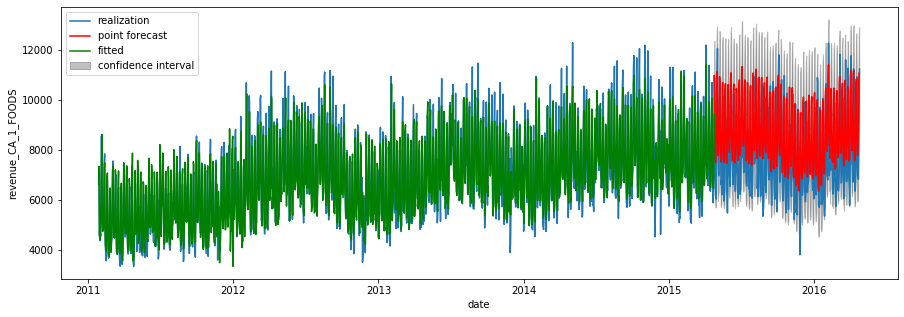

In [262]:
#Plot the results
plt.figure(figsize=(15, 5))
plt.plot(revenue_CA_1_FOODS_day)
plt.plot(forecast_point, color="red")
plt.plot(fitted_point, color="green")
plt.xlabel("date")
plt.ylabel("revenue_CA_1_FOODS")
plt.fill_between(lower_confidence_boundary.index, 
                     lower_confidence_boundary, 
                     upper_confidence_boundary, 
                     color="k", 
                     alpha=0.25)
plt.legend(("realization", "point forecast", "fitted", "confidence interval"),  
               loc="upper left")
plt.show()

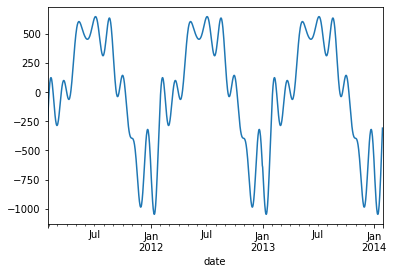

In [263]:
#Plotting individual seasonal components seperatly

#Yearly seasonality

#extracting the coefficients for the yearly fourier series components and multiplying them with the components values
yearly_seasonality = arima_exog_model.params()[1:21] * exog.loc[:,'yearly_sin365':'yearly_cos365_10']
#summing up each row to get the seasonal effect value per time point
yearly_seasonality = yearly_seasonality.sum(axis=1)
#plotting it for three years as the pattern remains the same
yearly_seasonality[0:1096].plot()

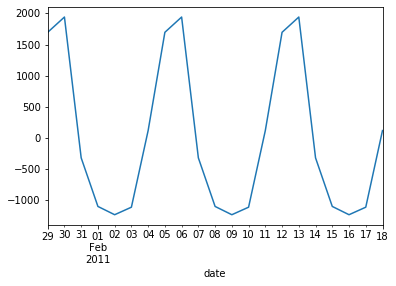

In [264]:
#Monthly seasonality

#extracting the coefficients for the monthly fourier series components and multiplying them with the components values
monthly_seasonality = arima_exog_model.params()[21:27] *exog.loc[:,'weekly_sin365':'weekly_cos365_3']
#summing up each row to get the seasonal effect value per time point
monthly_seasonality = monthly_seasonality.sum(axis=1)
#plotting it
#Note: only plotting the first 3 weeks as the pattern remains the same
monthly_seasonality[0:21].plot()

TypeError: float() argument must be a string or a number, not 'Period'

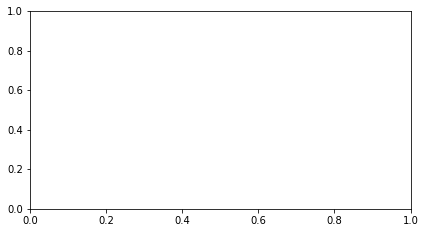

In [191]:
#Plotting diagnostics
#Source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ (Chapter 13)
#Note: somehow it only works if I first give out the fit of the model, 
#      Otherwise eror:  float() argument must be a string or a number, not 'Period' python
#      while in the example it works by simply plotting the model output

arima_exog_model.plot_diagnostics(lags=31,
                                  figsize=(15,8))
plt.show()


#Problem: it seems as if the plot_diagnostics cannot be done for a model including exogenous variables
#I can do it for the fit of a data set but thnen it excludes the explanatory variables
#Documentation: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html#pmdarima.arima.ARIMA.fit


#Interpretation:
#top left: we see the drops at christmas, otherwise errors seem to be distributed around zero randomly, 
#          perhaps a slight increase in variance over time due to the low variance in the first year
#top right: residuals are normally distributed with slight distortion to the left, probably due to christmas
#bottom left: confirms normal distribution and christmas distortion
#bottom right: strong correlation pattern in the weekly frequency which suggest that the models 
#              doesn't due a good job in catching weekly seasonality

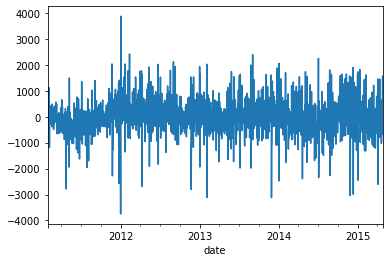

In [266]:
#plotting fittted errors and residuals
arima_exog_model.resid().plot()

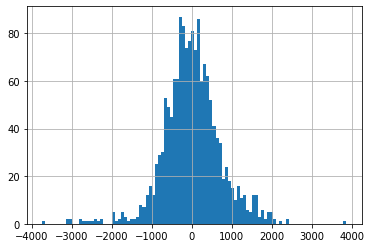

In [267]:
#Histogram of fitted errors and residuals shows approximately a bell curve
#Note there are ouliers into the negative (Christmas)
arima_exog_model.resid().hist(bins=100) #bins: defnes the number of bars

#https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.hist.html

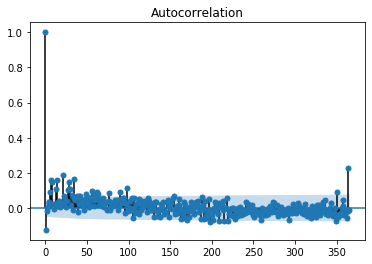

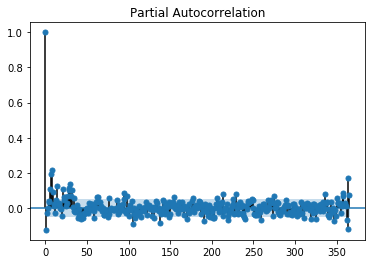

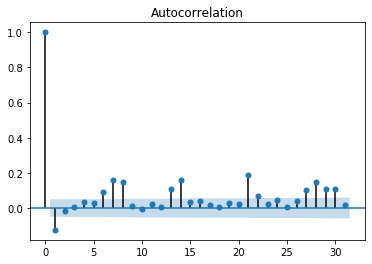

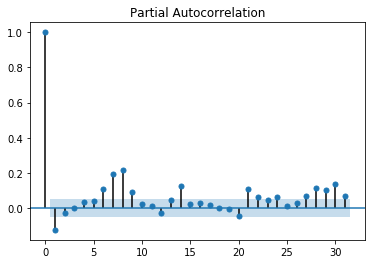

In [269]:
#ACf of residuals
plot_acf(arima_exog_model.resid(), lags=365)
plot_pacf(arima_exog_model.resid(), lags=365)
plot_acf(arima_exog_model.resid(), lags=31)
plot_pacf(arima_exog_model.resid(), lags=31)
plt.show()
#Note: if one includes "plt.show()" after a graph command it only shows the grap once

#Question: dont know how to include the plot_acf from statmodels into matplotlib
# That way I could make the graph larger and smaller

#Information from the plot for now:
#we see that every 7 days are significant in ACF and PACF
#Thus its seems as if weekly seasonality is not well accounted for or maybe their is monthely seasonality, not sure
#Idea: new seasonality at 28 day range or more sin and cos into the weekly seasonality
#Or just weekly Autocorrelation, maybe add a 7 day AR lag
#furthermore we have the one year lag also significant, suggesting that yearly seasonality is not well accounted for
#Or just yearly Autocorrelation, maybe add a 365 day AR lag

In [184]:
#H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
#H1: The data are not independently distributed; they exhibit serial correlation.
print(sm.stats.acorr_ljungbox(arima_exog_model.resid(), lags=[10], return_df=True))
print(sm.stats.acorr_ljungbox(fit_errors, lags=[10], return_df=True))
#Errors are not independent errors

#The Test:
#https://en.wikipedia.org/wiki/Ljung–Box_test
#https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

       lb_stat     lb_pvalue
10  113.865087  8.846745e-20
       lb_stat     lb_pvalue
10  113.865087  8.846745e-20
